In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas_datareader.yahoo.daily import YahooDailyReader
import pandas_datareader as web

from pypfopt import plotting, objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage


In [2]:
# tickers = ['NOVA', 'BEPC', 'CIO', 'JOE', 'CC', 'KWR', 'NET', 'BTRS', 'DXCM', 'MNKD', 'AJRD', 'CARR', 'AUB', 'UWMC', 
#             'CPE', 'FRO', 'TTCF', 'TSN', 'F', 'LNW', 'LUMN', 'GOGO']

# tickers = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'IYE', 'ITB', 'IYR', 'XLB', 'KBE', 'XHB', 'XME', 'XOP', 'KRE',
#            'XTL', 'XTL', 'XLK', 'XLU', 'GDX', 'GDXJ', 'OIH', 'SMH', 'VNQ']

tickers = ['ETLX.DE', 'IBCI.DE', 'G2X.DE', '2B78.DE', 'XDW0.DE', 'VOOM.DE', 'IS0D.DE', 'FLXG.DE', 'SPYY.DE', 
           'IUSL.DE', 'XDEB.DE', 'EUNL.DE', 'XDWD.DE', 'XDEQ.DE', 'EMWE.DE', 'USPY.DE', 'WTEM.DE', 'XDWH.DE', 
           'XDWT.DE']


# portfolio_type = "stock"
# portfolio_type = "etf_usa"
portfolio_type = "etf_ge"

start='01/01/2021'
end='12/31/2021'

total_portfolio_value = 50000

buy_date = '01/03/2022'
buy_date_week_end = '01/10/2022'
buy_date_month_end = '02/03/2022'

In [3]:
data = YahooDailyReader(symbols=tickers, 
                        start=start, end=end, 
                        retry_count=3, pause=0.1, session=None, adjust_price=False, ret_index=False, 
                        chunksize=1, interval='d', get_actions=False, adjust_dividends=True)
all_data = data.read()

In [4]:
adj_close_prices = all_data['Adj Close']

In [5]:
mu = ema_historical_return(adj_close_prices)
S = CovarianceShrinkage(adj_close_prices).ledoit_wolf()

In [6]:
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.2)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()

zero_allocation = [key for key in cleaned_weights if cleaned_weights[key] == 0]
cleaned_weights_final = {key: cleaned_weights[key] for key in cleaned_weights if key not in zero_allocation }

/Applications/anaconda3/envs/comp_invest/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Zero Allocation:  ['ETLX.DE', 'G2X.DE', '2B78.DE', 'USPY.DE']


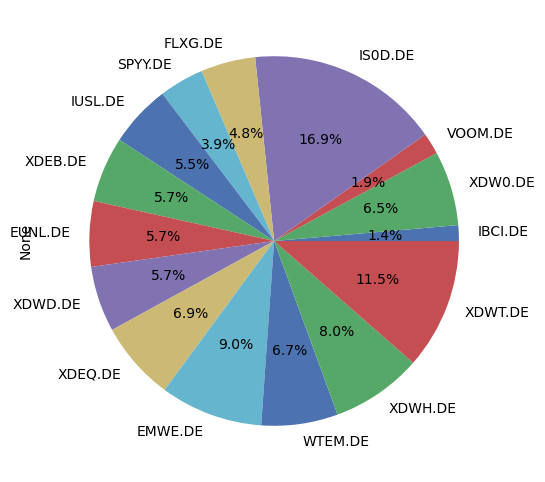

In [7]:
fig = pd.Series(cleaned_weights_final).plot.pie(figsize=(6,6), autopct='%1.1f%%').get_figure()
fig.savefig("results/MVO/cleaned_weights_"+portfolio_type+".png")

print("Zero Allocation: ", zero_allocation)

In [8]:
ef.portfolio_performance(verbose=True)

Expected annual return: 43.2%
Annual volatility: 13.6%
Sharpe Ratio: 3.02


(0.4319539571330796, 0.13642112367917547, 3.0197226501511647)

In [9]:
data_new = YahooDailyReader(symbols=tickers, 
                        start=buy_date, end=buy_date, 
                        retry_count=3, pause=0.1, session=None, adjust_price=False, ret_index=False, 
                        chunksize=1, interval='d', get_actions=False, adjust_dividends=True)
new_df = data_new.read()

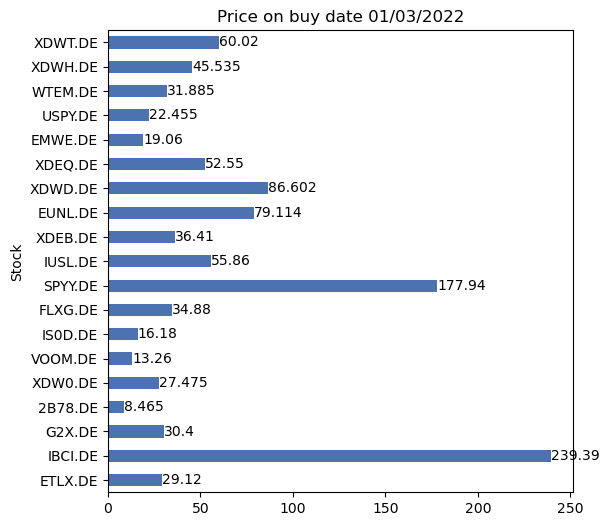

In [10]:
price_map = {}
for col in new_df['Open']:
    price_map[col] = new_df['Open'][col].iloc[0]
ax = pd.Series(price_map).plot.barh(figsize = (6,6), ylabel='Price', xlabel='Stock', title="Price on buy date " + buy_date)
ax.bar_label(ax.containers[0])
ax.get_figure().savefig("results/MVO/prices_buy_date_"+portfolio_type+".png")

In [11]:
price_map_pd = pd.Series(price_map.values(), index=price_map.keys())
da = DiscreteAllocation(weights, price_map_pd, total_portfolio_value=total_portfolio_value)

allocation, leftover = da.greedy_portfolio()
print("Allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Allocation: {'IS0D.DE': 521, 'XDWT.DE': 95, 'EMWE.DE': 235, 'XDWH.DE': 88, 'XDEQ.DE': 66, 'WTEM.DE': 105, 'XDW0.DE': 119, 'XDWD.DE': 33, 'XDEB.DE': 79, 'EUNL.DE': 36, 'IUSL.DE': 49, 'FLXG.DE': 68, 'SPYY.DE': 11, 'VOOM.DE': 70, 'IBCI.DE': 3}
Funds remaining: $1.34


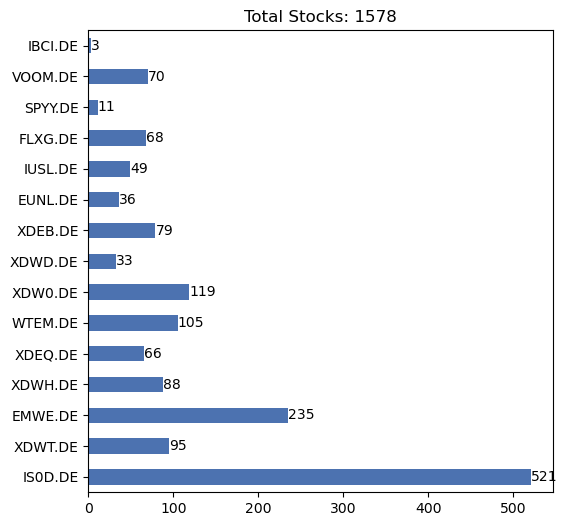

In [12]:
# pd.Series(share_allocations).plot.pie(figsize=(6,6), autopct='%1.1f%%')
ax = pd.Series(allocation).plot.barh(figsize=(6,6), title="Total Stocks: "+ str(sum(allocation.values())))
ax.bar_label(ax.containers[0])
ax.get_figure().savefig("results/MVO/allocation_"+portfolio_type+".png")

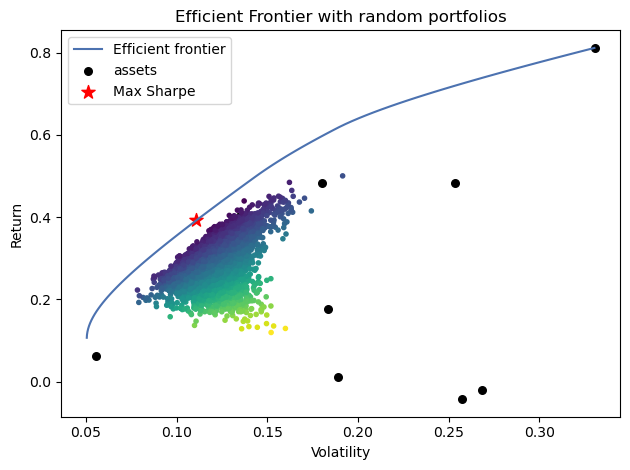

In [13]:
ef_new = EfficientFrontier(mu, S)

from pypfopt import plotting
ax = plotting.plot_efficient_frontier(ef_new, show_assets=True)

ef_max_sharpe = EfficientFrontier(mu, S)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("results/MVO/EF_scatter_"+portfolio_type+".png", dpi=200)
plt.show()

In [14]:
data_weekly = YahooDailyReader(tickers, start=buy_date, end=buy_date_week_end, 
                        retry_count=3, pause=0.1, session=None, adjust_price=False, ret_index=False, 
                        chunksize=1, interval='d', get_actions=False, adjust_dividends=True)
df_weekly = data_weekly.read()


data_monthly = YahooDailyReader(tickers, start=buy_date, end=buy_date_month_end,
                        retry_count=3, pause=0.1, session=None, adjust_price=False, ret_index=False, 
                        chunksize=1, interval='d', get_actions=False, adjust_dividends=True)
df_monthly = data_monthly.read()

In [15]:
df_monthly = df_monthly.dropna()

In [16]:
def open_price_extraction(df):
    price_map_open = {}
    for col in df['Open']:
        price_map_open[col] = df['Open'][col].iloc[0]
#     print('Opening prices for the period: ',price_map_open,end='\n\n')
    return(price_map_open)

def allocations(price_map, total_portfolio_value):

    price_map_pd = pd.Series(price_map.values(), index=price_map.keys())
#     print(price_map_pd)
    da = DiscreteAllocation(cleaned_weights, price_map_pd, total_portfolio_value)
    allocation, leftover = da.greedy_portfolio()

    return allocation

In [17]:
def close_price_extraction(df):
    price_map_close = {}
    for col in df['Close']:
        price_map_close[col] = df['Close'][col].iloc[-1]
#     print('Closing prices for the period: ',price_map_close, end='\n\n')
    return(price_map_close)

def returns_calc(price_map_close, allocation, total_portfolio_value):
    close_value = sum(price_map_close[key] * allocation[key] for key in allocation)
    returns = ((close_value - total_portfolio_value)/total_portfolio_value)*100
    print(f'Returns for the period: {returns}%',end='\n\n')
    return round(returns,2)

In [18]:
print('--Weekly returns data--\n')
weekly_open = open_price_extraction(df_weekly)
weekly_allocations = allocations(weekly_open, total_portfolio_value)
weekly_close = close_price_extraction(df_weekly)
weekly_returns = returns_calc(weekly_close, weekly_allocations, total_portfolio_value)

--Weekly returns data--

Returns for the period: -0.38219026947021484%



In [19]:
print('--Monthly returns data--\n')
monthly_open = open_price_extraction(df_monthly)
monthly_allocations = allocations(monthly_open, total_portfolio_value)
monthly_close = close_price_extraction(df_monthly)
monthly_returns = returns_calc(monthly_close, monthly_allocations, total_portfolio_value)

--Monthly returns data--

Returns for the period: -1.80521496963501%



In [20]:
df_weekly_ret = df_weekly['Adj Close'].pct_change(1).dropna()

ret = dict(df_weekly_ret.mean())
temp_ret = sum([ret[k]*cleaned_weights[k] for k in ret])
# exp_ret = sum([(252 ** 0.5) * k for k in temp_ret])

sd = dict(df_weekly_ret.std())
temp_sd = [sd[k]*cleaned_weights[k] for k in sd]
exp_sd = sum([k for k in temp_sd])

# Calculate the Sharpe Ratio.
sharpe_ratio_weekly = round(temp_ret / exp_sd,2)
print(sharpe_ratio_weekly)

-0.06


In [21]:
df_monthly_ret = df_monthly['Adj Close'].pct_change(1).dropna()

ret = dict(df_monthly_ret.mean())
temp_ret = sum([ret[k]*cleaned_weights[k] for k in ret])
# exp_ret = sum([(252 ** 0.5) * k for k in temp_ret])

sd = dict(df_monthly_ret.std())
temp_sd = [sd[k]*cleaned_weights[k] for k in sd]
exp_sd = sum([k for k in temp_sd])

# Calculate the Sharpe Ratio.
sharpe_ratio_monthly = round(temp_ret / exp_sd,2)
print(sharpe_ratio_monthly)

-0.05


In [22]:
d = {'Index Title': ['weekly', 'monthly']}#, 'Sortino Ratio'
dump_df = pd.DataFrame(d).set_index('Index Title')
dump_df['% Return'] = [weekly_returns, monthly_returns]
dump_df['Sharpe Ratio'] = [sharpe_ratio_weekly, sharpe_ratio_monthly]
dump_df

,% Return,Sharpe Ratio
Index Title,,
weekly,-0.38,-0.06
monthly,-1.81,-0.05


In [23]:
import pickle

with open("metrics_"+portfolio_type+".pickle","ab") as f:
    pickle.dump(dump_df, f)

In [24]:
price_data = web.get_data_yahoo(tickers, start=buy_date, end='12/01/2022')
price_data = price_data['Adj Close']

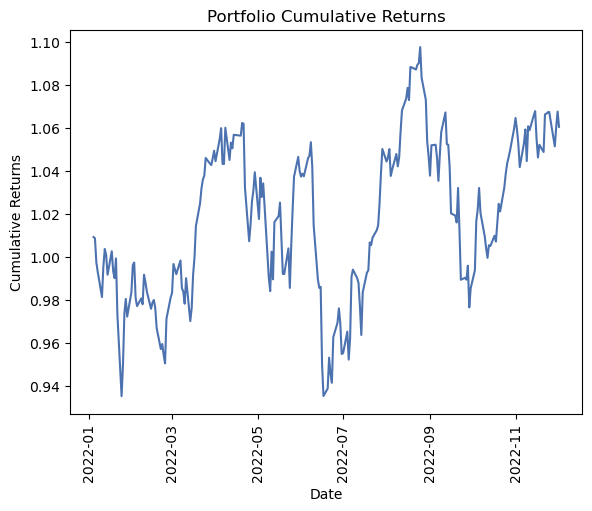

In [25]:
returns_data = price_data.pct_change()[1:]
weighted_returns = (cleaned_weights * returns_data)

portfolio_returns = weighted_returns.sum(axis=1)
cumulative_ret = (portfolio_returns + 1).cumprod()

fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(cumulative_ret)
ax1.set_xlabel('Date')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Portfolio Cumulative Returns")
plt.xticks(rotation = 90)
plt.savefig("results/MVO/cumm_returns_"+portfolio_type+".png")
plt.show()

with open("results/MVO/cum_return_" + portfolio_type+".pickle","wb") as f:
    pickle.dump(cumulative_ret, f)

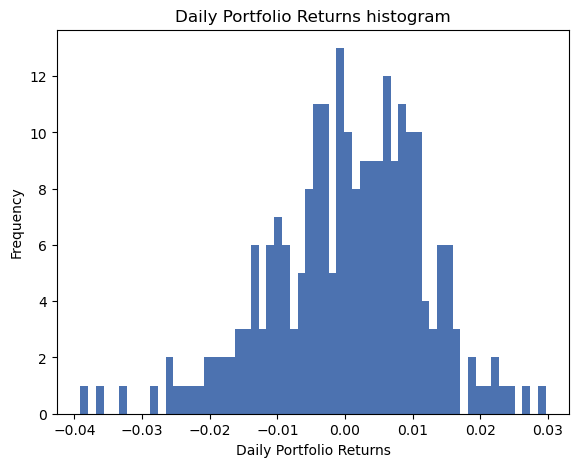

In [26]:
returns_data = price_data.pct_change()[1:]
weighted_returns = cleaned_weights * returns_data
portfolio_returns = weighted_returns.sum(axis=1)

fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.hist(portfolio_returns, bins = 60)
ax1.set_xlabel('Daily Portfolio Returns')
ax1.set_ylabel("Frequency")
ax1.set_title("Daily Portfolio Returns histogram")
plt.savefig("results/MVO/returns_histogram_" + portfolio_type + ".png")
plt.show(); 

with open("results/MVO/weighted_return_"+portfolio_type+".pickle","wb") as f:
    pickle.dump(weighted_returns, f)